# **1. Preparing the Data**
Je suis allée prendre un dataset depuis GitHub : ``https://github.com/YoongiKim/CIFAR-10-images``

In [1]:
import os
import torch
import torchvision

from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

## **1. Data transformation (normalization and augmentation)**

On va prendre exceptionnellement tout le trainset pour train et le testset pour val

``RandomCrop`` : 
- pad each image by 4 pixels
- take a random crop of size 32x32
- mode:'reflect' ca remplit le vide avec le miroir de l'image

``RandomHorizontalFlip`` : flip the image horizontally with a 50% probability

In [4]:
stats=((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
train_tfms=tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect'),
                      tt.RandomHorizontalFlip(), #avec une proba de 50%
                      tt.ToTensor(),
                      tt.Normalize(*stats)])
val_tfms=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

In [5]:
train_ds=ImageFolder('/kaggle/input/cifar10/train',transform=train_tfms)
val_ds=ImageFolder('/kaggle/input/cifar10/test',transform=val_tfms)

In [ ]:
len(train_ds)

In [ ]:
print(train_ds.classes)

## **2. Create dataloaders**

``num_workers`` : can be used to leverage multiple CPU cores and load images in parallel. 

``pin_memory`` : avoid repeated memory allocation and dealllocation by using the same portion of memory (RAM) for loading each batch of data.

``suffle=True`` : when an epoch starts, it shuffles the train_dl and then creates batches. At the end of one epoch, it shuffles them again and then new batches come. It helps the model generalize by seing more variety.

In [6]:
from torch.utils.data import DataLoader

batch_size=256
train_dl=DataLoader(train_ds,batch_size,shuffle=True,
                   num_workers=8,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size,shuffle=False,
                 num_workers=8,pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# **2. Visualiser les images**

On le fait juste pour le premier batch et les 100 premières images du batch.

Les images sont bizarres à cause de toutes les transformations faites.
Les couleurs sont changées à cause de la normalisation.

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    for images,labels in dl:
        fig,ax=plt.subplots(figsize=(16,16))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(images[:100],10).permute(1,2,0))
        break

In [ ]:
show_batch(train_dl)

# **3. Defining the Model (WideResNet22)**

**22** : 22 convolutional layers

**residual blocs** : adds the original input ack to the output feature map obtained by passing the input through one or more convolutional layers.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.relu1=nn.ReLU()
        self.conv2=nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()

    def forward(self,x):
        out=self.conv1(x)
        out=self.relu1(out)
        out=self.conv2(out)
        return self.relu2(out + x)

In [9]:
simple_resnet=SimpleResidualBlock()

for images,labels in train_dl:
    out=simple_resnet(images)
    print(out.shape)
    break

torch.Size([256, 3, 32, 32])


In [10]:
def conv_2d(ni,nf,stride=1,ks=3):
    return nn.Conv2d(in_channels=ni,out_channels=nf,
                    kernel_size=ks,stride=stride,
                    padding=ks//2,bias=False)

def bn_relu_conv(ni,nf):
    return nn.Sequential(nn.BatchNorm2d(ni),
                       nn.ReLU(inplace=True),
                       conv_2d(ni,nf))

class ResidualBlock(nn.Module):
    def __init__(self,ni,nf,stride=1):
        super().__init__()
        self.bn=nn.BatchNorm2d(ni)
        self.conv1=conv_2d(ni,nf,stride)
        self.conv2=bn_relu_conv(nf,nf)
        self.shortcut=lambda x: x #c'est une fonction qui retourne l'input
        if ni!=nf:
            self.shortcut=conv_2d(ni,nf,stride,1)

    def forward(self,x):
        x=F.relu(self.bn(x),inplace=True)
        r=self.shortcut(x)
        x=self.conv1(x)
        x=self.conv2(x)*0.2 #scaling factor (ca marche mieux)
        return x.add_(r)

In [11]:
def make_group(N,ni,nf,stride):
    start=ResidualBlock(ni,nf,stride)
    rest=[ResidualBlock(nf,nf)for j in range(1,N)]
    return [start]+rest

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        return x.reshape(x.size(0),-1)

class WideResNet(nn.Module):
    def __init__(self,n_groups,N,n_classes,k=1,n_start=16):
        super().__init__()
        #increase channels to n_start using conv layer
        layers=[conv_2d(3,n_start)]
        n_channels=[n_start]

        #add groups of BasicBlock(increase channels and downsample)
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride=2 if i>0 else 1
            layers += make_group(N,n_channels[i],
                                n_channels[i+1],stride)

        #Pool, flatten and and linear layer for classification
        layers += [nn.BatchNorm2d(n_channels[3]),
                  nn.ReLU(inplace=True),
                  nn.AdaptiveAvgPool2d(1),
                  Flatten(),
                  nn.Linear(n_channels[3],n_classes)]

        self.features=nn.Sequential(*layers)

    def forward(self,x):
        return self.features(x)

def wrn_22():
    return WideResNet(n_groups=3,N=3,n_classes=10,k=6)

In [35]:
model=wrn_22()

In [ ]:
model

In [ ]:
for images,labels in train_dl:
    print(f'images.shape : {images.shape}')
    out=model(images)
    print(f'out.shape : {out.shape}')
    break

# **4. Training the model**

``data = DataLoaders.from_dsets(train_ds, val_ds, bs=batch_size)`` : on crée un dataloader à partir de deux ensembles de données PyTorch (train et validation)

``learner = Learner(data, model, loss_func=F.cross_entropy, metrics=[accuracy])`` : on crée un learner, objet central dans fast.ai
 - Ce Learner va s’occuper de tout : entraînement, évaluation, sauvegarde, affichage de résultats, etc.

``learner.add_cb(GradientClip(0.1))`` : on ajoute une "callback" qui va empêcher les gradients d’exploser
 - ``GradientClip(0.1)`` : empêche les gradients d’avoir une norme plus grande que 0.1 pendant la backpropagation
 - C’est utile si ton modèle est instable à l’entraînement (perte qui diverge)

In [13]:
from fastai.vision.all import *

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
data = DataLoaders.from_dsets(train_ds, val_ds, bs=batch_size,device=device)

learner = Learner(
    data,
    model,
    loss_func=F.cross_entropy,
    metrics=[accuracy]
)

learner.add_cb(GradientClip(0.1))

In [21]:
print(type(learner))

<class 'fastai.learner.Learner'>


SuggestedLRs(valley=0.0003311311302240938)

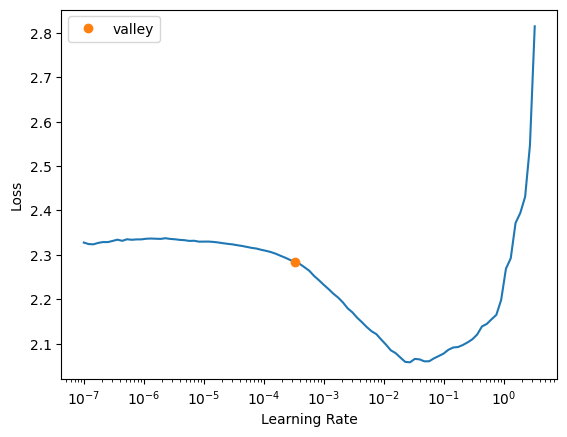

In [17]:
learner.lr_find()

Based on the above graph, it seems like a ``learning rate of 5e-3`` leads to the fastest reduction in loss.

In [37]:
learner.fit_one_cycle(9,5e-3,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.353218,1.405522,0.515000,01:18
1,1.048936,1.287282,0.601700,01:17
2,0.819117,0.946685,0.682100,01:17
3,0.672720,0.760024,0.747600,01:17
4,0.571360,0.644740,0.785400,01:17
5,0.476488,0.493970,0.829200,01:17
6,0.395191,0.427121,0.854000,01:17
7,0.323864,0.396749,0.867000,01:18
8,0.290000,0.386500,0.869400,01:18


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

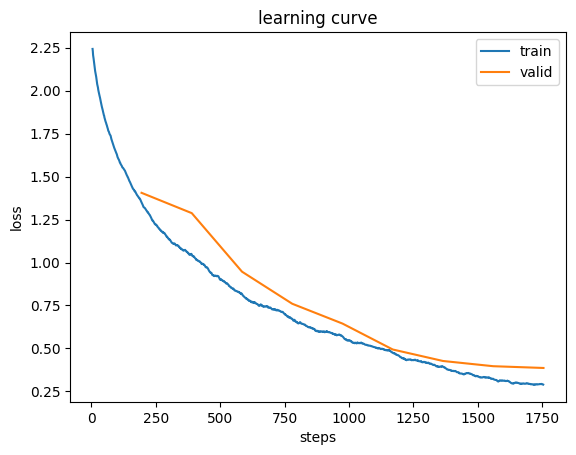

In [39]:
learner.recorder.plot_loss()